In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv"
df = pd.read_csv(url, sep = '\t')
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


#### 1. Вывести: кол-во наблюдений в датасете

In [3]:
df.shape[0]

4622

#### 2. Вывести названия столбцов

In [5]:
print(*df.columns, sep = ', ')

order_id, quantity, item_name, choice_description, item_price


#### 3. Определить самую частую позицию (item) в заказе 

In [64]:
print(*df['item_name'].mode())

Chicken Bowl


#### 4. Построить гистрограмму частоты заказов по позициям (item)

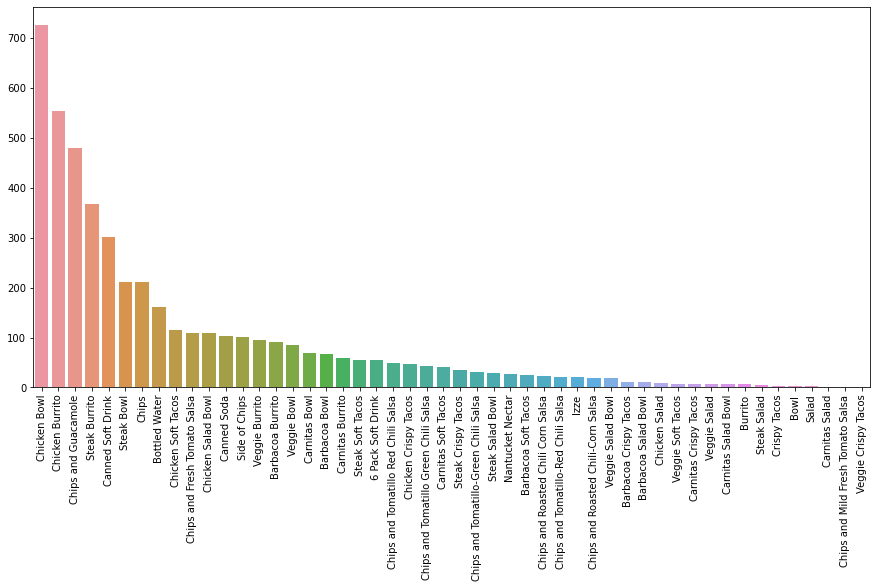

In [7]:
item_count = df['item_name'].value_counts()
plt.figure(figsize=(15,7))
sns.barplot(item_count.index, item_count.values)
plt.xticks(rotation=90)
plt.show()

#### 5. Измените тип переменной item_price c с помощью лямбды функции

In [8]:
df['item_price'] = df['item_price'].apply(lambda x: float(x[1:]))

#### 6. Построить гистограмму кол-во денег заработанных по каждой позиции (item)

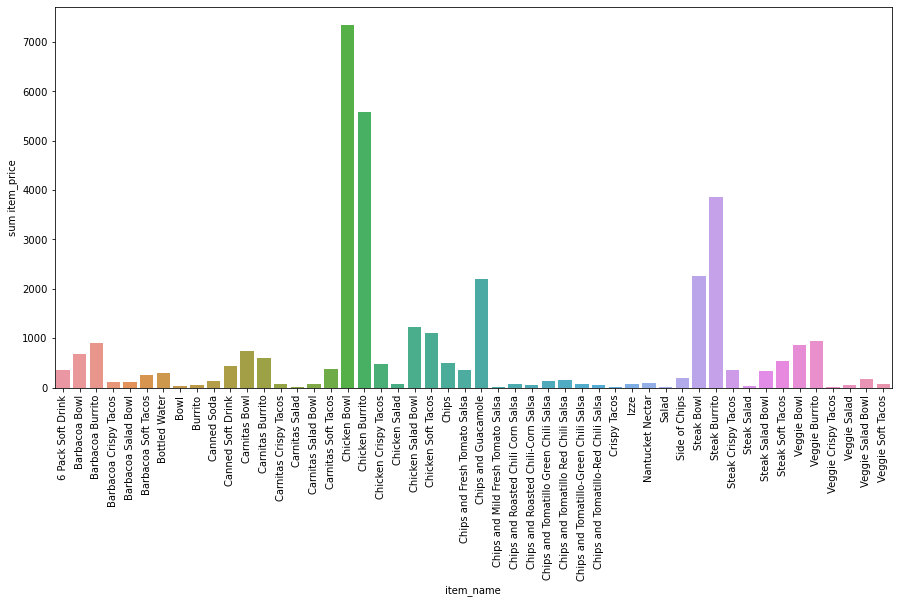

In [9]:
item_cost = df.groupby(['item_name']).sum()
plt.figure(figsize=(15,7))
sns.barplot(item_cost.index, item_cost.item_price)
plt.ylabel('sum item_price')
plt.xticks(rotation=90)
plt.show()

#### 7. Средняя сумма заказа? (минимум 2 способа)

In [31]:
round(df.groupby(['order_id']).sum().mean().item_price, 2)

18.81

In [29]:
round(df['item_price'].sum()/df['order_id'].nunique(), 2)

18.81

#### 8. Выведите среднее, минимальное и максимальное, медианное значения позиций в заказе

In [45]:
df.groupby(['order_id']).nunique().item_name.agg(['mean', 'min', 'max', 'median'])

mean      2.34024
min       1.00000
max       8.00000
median    2.00000
Name: item_name, dtype: float64

#### 9. Определить статистику заказов стейков, а также статистику заказов прожарки.

In [60]:
steaks = df[df['item_name'].str.contains('Steak')]
steaks.describe().drop(['order_id'], axis=1)

,quantity,item_price
count,702.000000,702.000000
mean,1.045584,10.518889
std,0.228314,2.566743
min,1.000000,8.690000
25%,1.000000,8.990000
50%,1.000000,9.250000
75%,1.000000,11.750000
max,3.000000,27.750000


In [62]:
sauce = df[df['choice_description'].str.contains('Hot|Mild|Medium', na=False)]
sauce.describe().drop(['order_id'], axis=1)

,quantity,item_price
count,783.000000,783.000000
mean,1.054917,9.772031
std,0.238920,2.588239
min,1.000000,8.190000
25%,1.000000,8.490000
50%,1.000000,8.990000
75%,1.000000,10.980000
max,3.000000,32.940000


#### 10. Добавить новый столбец цен на каждую позицию в заказе в рублях.

In [68]:
rub = 71.60
df['price_rub'] = round(df['item_price']*rub, 2)

In [70]:
df.head()

,order_id,quantity,item_name,choice_description,item_price,price_rub
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,171.12
1,1,1,Izze,[Clementine],3.39,242.72
2,1,1,Nantucket Nectar,[Apple],3.39,242.72
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,171.12
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,1215.77


#### 11. Сгруппировать заказы по входящим позициям в него. Отдельно сгруппировать по стейкам во всех видах прожарках.

#### 12. Определить цену по каждой позиции в отдельности. 

### Алгоритмы уменьшения размерности 

#### повторить эксперименты в главе 5.1 Qalitative Comparison of Multiple Algorithms статьи статьи UMAP: Uniform Manifold
#### Approximation and Projection for Dimension Reduction (https://arxiv.org/pdf/1802.03426.pdf)

#### необходимо воспроизвести все графики данной главы, соотнести выводы из статьи с вашими результатами.